# Find Me  
**Michael duPont - CodeCamp 2017**

---

## Find Faces

The first thing we need to do is pick out faces from a larger image. Because the model for this is not user or case specific, we can use an existing model, load it with OpenCV, and tune the hyperparameters instead of building one from scratch, which we will have to do later.

In [1]:
import cv2
import numpy as np

CASCADE = cv2.CascadeClassifier('findme/haar_cc_front_face.xml')

def find_faces(img: np.ndarray, sf=1.16, mn=5) -> np.array([[int]]):
    """Returns a list of bounding boxes for every face found in an image"""
    return CASCADE.detectMultiScale(
        cv2.cvtColor(img, cv2.COLOR_RGB2GRAY),
        scaleFactor=sf,
        minNeighbors=mn,
        minSize=(45, 45),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

That's really all we need. Now let's test it by drawing rectangles around a few images of groups. Here's one example:

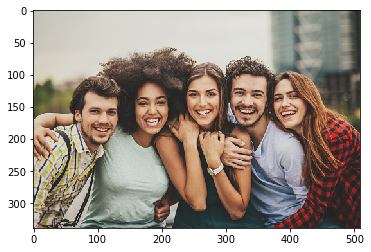

In [2]:
import matplotlib.pyplot as plt
from matplotlib.image import imread, imsave
%matplotlib inline

plt.imshow(imread('test_imgs/group0.jpg'))

[[152 118  67  67]
 [231 105  67  67]
 [362 112  61  61]
 [ 73 132  70  70]
 [298 102  74  74]]
[[303  60  57  57]
 [368 100  65  65]
 [466  49  60  60]
 [ 68  62  68  68]
 [168  71  59  59]
 [235 120  57  57]]
[[417  49  73  73]
 [767  35  87  87]]
[[ 80  86  54  54]
 [229  95  51  51]]
[[176 121  76  76]
 [450  73  67  67]
 [244  83  72  72]
 [633  30  85  85]
 [114  46  73  73]
 [358  96  83  83]
 [527  91  83  83]
 [171 200  79  79]]


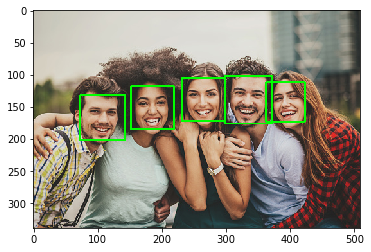

In [3]:
from glob import glob

def draw_boxes(bboxes: [[int]], img: 'np.array', line_width: int=2) -> 'np.array':
    """Returns an image array with the bounding boxes drawn around potential faces"""
    for x, y, w, h in bboxes:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), line_width)
    return img

#Find faces for each test image
for fname in glob('test_imgs/group*.jpg'):
    img = imread(fname)
    bboxes = find_faces(img)
    print(bboxes)
    imsave(fname.replace('/', '/find_faces/'), draw_boxes(bboxes, img))

plt.imshow(imread('test_imgs/find_faces/group0.jpg'))

After tuning the hyperparameters, we're getting good face identification over our test images.

## Build Dataset

### Base Corpus

Now let's use this to build a base corpus of "these faces are not mine" so we can augment it later with the face we want to target.

test_imgs/group0.jpg
test_imgs/group1.jpg
test_imgs/group2.jpg
test_imgs/group3.jpg
test_imgs/group4.jpg
Total number of base corpus faces found: 23


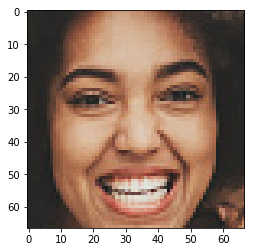

In [4]:
#Creates cropped faces for imgs matching 'test_imgs/group*.jpg'

def crop(img: np.ndarray, x: int, y: int, width: int, height: int) -> np.ndarray:
    """Returns an image cropped to a given bounding box of top-left coords, width, and height"""
    return img[y:y+height, x:x+width]

def pull_faces(glob_in: str, path_out: str) -> int:
    """Pulls faces out of images found in glob_in and saves them as path_out
    Returns the total number of faces found
    """
    i = 0
    for fname in glob(glob_in):
        print(fname)
        img = imread(fname)
        bboxes = find_faces(img)
        for bbox in bboxes:
            cropped = crop(img, *bbox)
            imsave(path_out.format(i), cropped)
            i += 1
    return i

found = pull_faces('test_imgs/group*.jpg', 'test_imgs/corpus/face{}.jpg')

print('Total number of base corpus faces found:', found)
plt.imshow(imread('test_imgs/corpus/face0.jpg'))

Now that we have some faces to work with, let's save them to a pickle file for use later on.

In [5]:
from pickle import dump

#Creates base_corpus.pkl from face imgs in test_imgs/corpus
imgs = [imread(fname) for fname in glob('test_imgs/corpus/face*.jpg')]
dump(imgs, open('findme/base_corpus.pkl', 'wb'))

### Target Corpus

Now we need to add our target data. Since this is going to power a personal project, I'm going to train it to recognize my face. Other than adding some new images, we can reuse the code from before but just supplying a different glob string.

test_imgs/me1.jpg
test_imgs/me2.jpg
test_imgs/me3.jpg
test_imgs/me4.jpg
test_imgs/me5.jpg
Total number of target faces found: 8


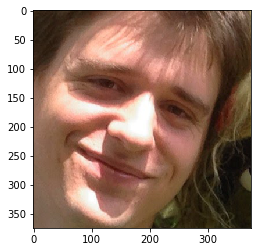

In [6]:
found = pull_faces('test_imgs/me*.jpg', 'test_imgs/corpus/me{}.jpg')

print('Total number of target faces found:', found)
plt.imshow(imread('test_imgs/corpus/me0.jpg'))

That was easy enough.

### Model Training Data

Now that we have our faces, we need to create the features and labels that will be used to train our facial recognition model. We've already classified our data based on the face's filename; all we need to do is assign a 1 or 0 to each group for our labels. We'll also need to scale each image to a standard size. Thankfully the output for each bounding box is a square, so we don't have to worry about introducing distortions.

In [7]:
#Load the two sets of images
from pickle import load

notme = load(open('findme/base_corpus.pkl', 'rb'))
me = [imread(fname) for fname in glob('test_imgs/corpus/me*.jpg')]

#Create features and labels
features = notme + me
labels = [0] * len(notme) + [1] * len(me)

#Preprocess images for the model
def preprocess(img: np.ndarray) -> np.ndarray:
    """Resizes a given image and remove alpha channel"""
    img = cv2.resize(img, (45, 45), interpolation=cv2.INTER_AREA)[:,:,:3]
    return img

features = [preprocess(face) for face in features]

Simple enough. Let's do a quick check before shuffling. The first image should be part of the base corpus:

Is the target: False


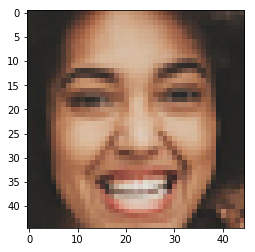

In [8]:
print('Is the target:', labels[0] == 1)
plt.imshow(features[0], cmap='gray')

And the last image should be of the target:

Is the target: True


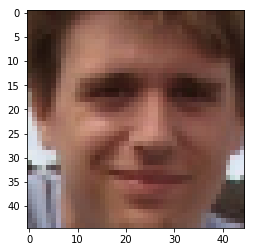

In [9]:
print('Is the target:', labels[-1] == 1)
plt.imshow(features[-1], cmap='gray')

Looks good. Let's create a quick data and file checkpoint. This means we'll be able to load the file in from this point on without having to run most of the above code.

In [10]:
#Convert into numpy arrays
features = np.array(features)
labels = np.array(labels)

dump(features, open('test_imgs/features.pkl', 'wb'))
dump(labels, open('test_imgs/labels.pkl', 'wb'))

#### DATA/FILE CHECKPOINT

The notebook can be run from scratch from this point onward.

In [ ]:
# DATA/FILE CHECKPOINT
from pickle import load
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread, imsave
%matplotlib inline
from findme.imageutil import crop, draw_boxes, preprocess
from findme.models import find_faces

features = load(open('test_imgs/features.pkl', 'rb'))
labels = load(open('test_imgs/labels.pkl', 'rb'))

That's it for our data. We'll split our data in the next section.

# Am I in This?

We've already Now for the model we're going to train. First we need to define our model architecture one layer at a time. We'll create two convolutional layers, two fully-connected layers, and the output layer.

In [ ]:
from keras.layers import Activation, Convolution2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential

SHAPE = features[0].shape

def make_model() -> Sequential:
    """Create a Sequential Keras model to boolean classify faces"""
    model = Sequential()
    # First Convolution
    model.add(Convolution2D(32, (5, 5), input_shape=SHAPE))
    model.add(Activation('relu'))
    model.add(Dropout(.2))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # Second Convolution
    model.add(Convolution2D(32, (5, 5)))
    model.add(Activation('relu'))
    model.add(Dropout(.2))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # Flatten for Fully Connected
    model.add(Flatten())
    # First Fully Connected
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    # Second Fully Connected
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    # Output
    model.add(Dense(1)) #2
    model.add(Activation('softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #print(model.summary())
    return model

Now we need to train the model.

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.utils import shuffle

model = KerasClassifier(build_fn=make_model, epochs=5, batch_size=len(labels), verbose=0)
model.fit(*shuffle(features, labels, random_state=42))

That's it. While Keras has its own mechanisms for training and validating models, we're using a wrapper around our Keras model so it conforms to the Scikit-Learn model API. We can use `fit` and `predict` when working with the model in our code, and it let's us train and use our model with the other helper modules sk-learn provides. For example, we could have evaluated the model using StratifiedKFold and cross_val_score which would look like this:

```python
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

model = KerasClassifier(build_fn=make_model, epochs=5, batch_size=len(labels), verbose=0)

# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
result = cross_val_score(model, features, labels, cv=kfold)
print(result.mean())
```

This method allows us to determine how effective our model is but does not return a trained model for us to use.

In [ ]:
print('Predicts correctly for target in training data:',
      model.predict(np.array([features[-2]]))[0][0] == 1)

## Putting It Together

Lastly, let's create a single function that takes in an image and returns if the target was found and where.

First we'll load in our test image.

In [ ]:
test_img = imread('test_imgs/evaluate/me1.jpg')
plt.imshow(test_img)

Now for the function itself. Because we've already made function around the core parts of our data pipeline, this function is going to be incredibly short yet powerful.

In [ ]:
def target_in_img(img: np.ndarray) -> (bool, np.array([int])):
    """Returns whether the target is in a given image and where"""
    for bbox in find_faces(img):
        face = preprocess(crop(img, *bbox))
        if model.predict(np.array([face])) == 1:
            return True, bbox
    return False, None

Yeah. That's it. Let's break down the steps:

- `find_faces` returns a list of bounding boxes containing faces
- We prepare each face by cropping the image to the bounding box, scaling to 45x45, and removing the alpha channel
- The `model` predicts whether the face is or is not the target
- If the target is found (`pred == 1`), return True and the current bounding box
- If there aren't any faces or none of the faces belongs to the target, return False and None

Now let's test it. If it works properly, we should see a bounding bx appear around the target's face.

In [ ]:
found, bbox = target_in_img(test_img)

print('Target face found in test image:', found)
if found:
    plt.imshow(draw_boxes([bbox], test_img, line_width=20))

We're finally done.